<a href="https://colab.research.google.com/github/sachinv899/300Days__MachineLearningDeepLearning/blob/main/SIgn_with_COCO_dataformat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Microcontroller Instance Segmentation with COCO dataformat
<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/blob/master/Microcontroller_Instance_Segmentation_with_COCO_dataformat.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/blob/master/Microcontroller_Instance_Segmentation_with_COCO_dataformat.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

## Install detectron2

> **Important**: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md). This notebook includes only what's necessary to run in Colab.

In [1]:
!python -m pip install pyyaml==5.1
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
# so we install from source instead. This takes a few minutes.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Install pre-built detectron2 that matches pytorch version, if released:
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/{CUDA_VERSION}/{TORCH_VERSION}/index.html

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 18.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp310-cp310-linux_x86_64.whl size=44090 sha256=07a8b3fac45067baf1e8c1f74e309a69feb3ff0b76880d482c7051c37b57a917
  Stored in directory: /root/.cache/pip/wheels/70/83/31/975b737609aba39a4099d471d5684141c1fdc3404f97e7f68a
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.12.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
flax 0.6.9 requires PyYAML>=5.4.1, but you have pyyaml 5.1 which is incompatibl

In [2]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
torch:  2.0 ; cuda:  cu118
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu118/torch2.0/index.html


In [3]:

import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.6


## Get data

In [4]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [5]:
!wget https://raw.githubusercontent.com/Priyeshprajapati/test12/main/microcontroller_segmentation_data.zip
!unzip microcontroller_segmentation_data.zip
!ls


--2023-05-21 10:24:23--  https://raw.githubusercontent.com/Priyeshprajapati/test12/main/microcontroller_segmentation_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12332306 (12M) [application/zip]
Saving to: ‘microcontroller_segmentation_data.zip’

microcontroller_seg 100%[===================>]  11.76M  --.-KB/s    in 0.05s   

2023-05-21 10:24:24 (239 MB/s) - ‘microcontroller_segmentation_data.zip’ saved [12332306/12332306]

Archive:  microcontroller_segmentation_data.zip
  inflating: Microcontroller Segmentation/test.json  
   creating: Microcontroller Segmentation/test/
  inflating: Microcontroller Segmentation/test/033902b97317e31f23bae7452eda3364.json  
  inflating: Microcontroller Segmentation/test/033902b97317e31f23bae7452eda3364.png  
  inf

In [6]:
!ls 'Microcontroller Segmentation'

test  test.json  train	train.json


## Register data-set

In order to use a dataset with Detectron2 we need to register it. For more information check out the official documentation.

In [7]:
from detectron2.data.datasets import register_coco_instances

for d in ["train", "test"]:
    register_coco_instances(f"microcontroller_{d}", {}, f"Microcontroller Segmentation/{d}.json", f"Microcontroller Segmentation/{d}")

WARNING [05/21 10:24:44 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/21 10:24:44 d2.data.datasets.coco]: Loaded 86 images in COCO format from Microcontroller Segmentation/train.json


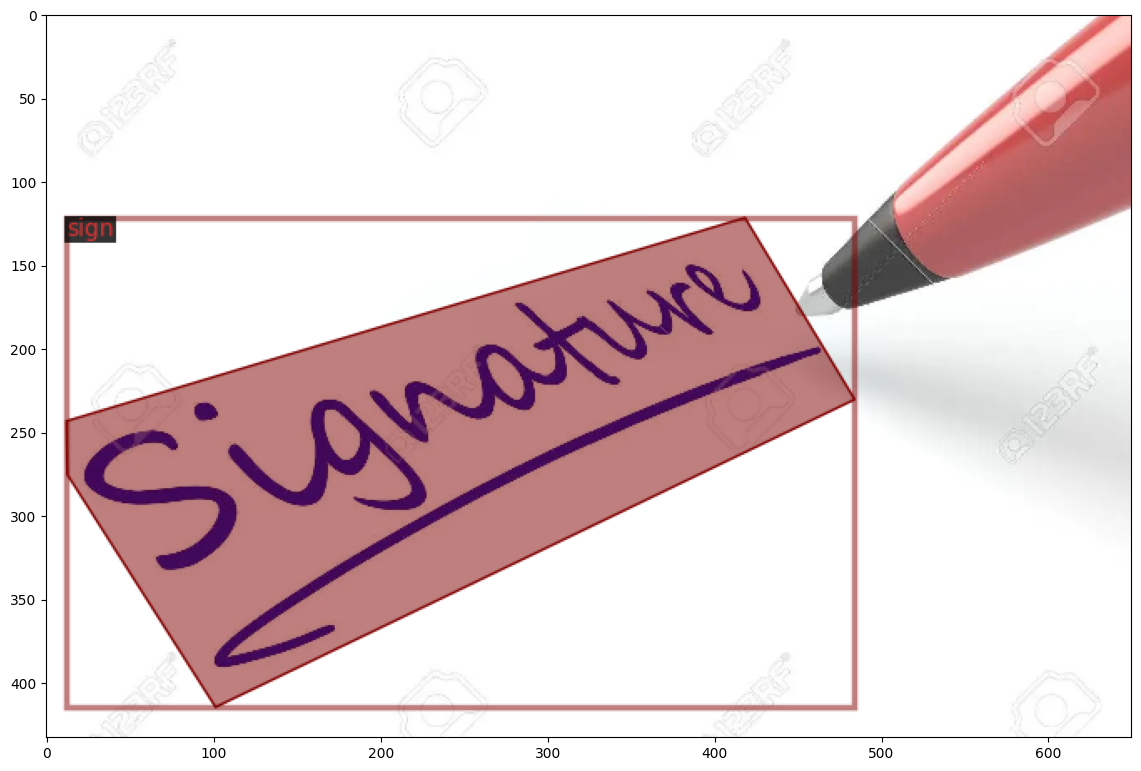

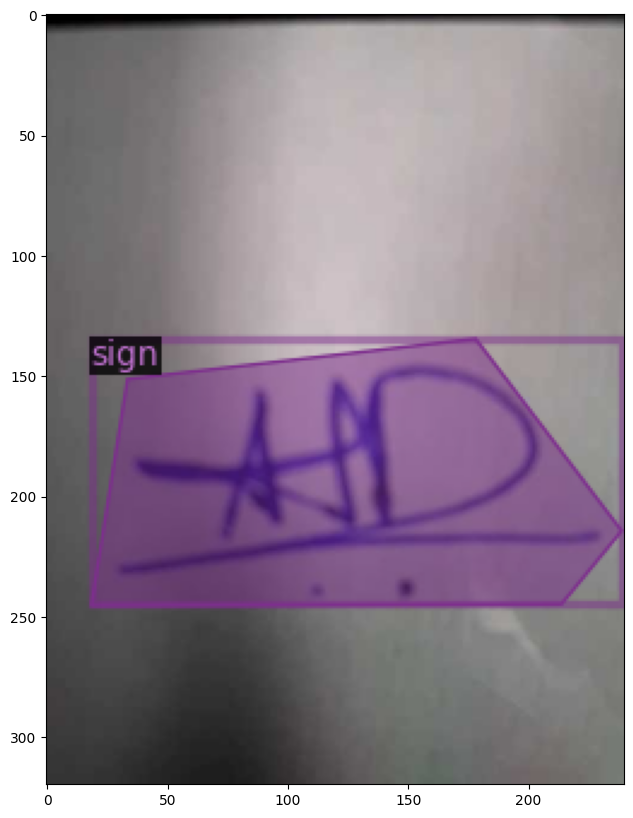

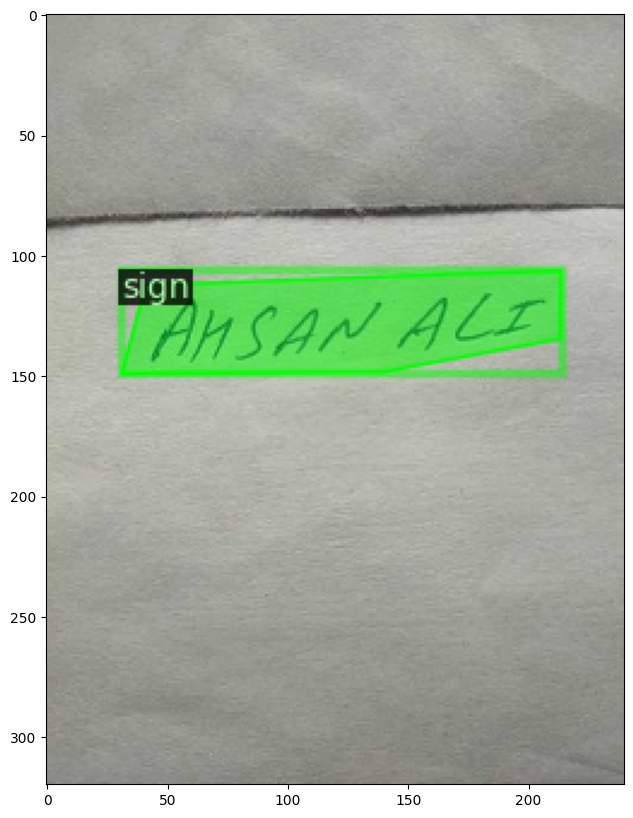

In [8]:
import random
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_dicts = DatasetCatalog.get("microcontroller_train")
microcontroller_metadata = MetadataCatalog.get("microcontroller_train")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=microcontroller_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [9]:
#test*******************************

In [10]:
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
import copy
import torch

def custom_mapper(dataset_dict):
    dataset_dicts = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
        T.Resize((800,600)),
        T.RandomBrightness(0.8, 1.8),
        T.RandomContrast(0.6, 1.3),
        T.RandomSaturation(0.8, 1.4),
        T.RandomRotation(angle=[90, 90]),
        T.RandomLighting(0.7),
        T.RandomFlip(prob=0.4, horizontal=False, vertical=True),
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dicts

In [11]:
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_test_loader, build_detection_train_loader

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

## Train model

Now, let's fine-tune a pretrained FasterRCNN instance segmentation model on the microcontroller data-set.

In [12]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("microcontroller_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()


# from detectron2.config import get_cfg

# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
# cfg.DATASETS.TRAIN = ("microcontroller_train",)
# cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
# cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # initialize from model zoo
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.BASE_LR = 0.00025
# cfg.SOLVER.MAX_ITER = 500
# cfg.SOLVER.STEPS = []        # do not decay learning rate
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = CustomTrainer(cfg) 
# trainer.resume_or_load(resume=False)
# trainer.train()

[05/21 10:24:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 143MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[05/21 10:24:57 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/21 10:25:10 d2.utils.events]:  eta: 0:07:16  iter: 19  total_loss: 2.314  loss_cls: 1.49  loss_box_reg: 0.08888  loss_mask: 0.694  loss_rpn_cls: 0.008887  loss_rpn_loc: 0.01233    time: 0.4396  last_time: 0.3455  data_time: 0.0139  last_data_time: 0.0046   lr: 4.9953e-06  max_mem: 2672M
[05/21 10:25:24 d2.utils.events]:  eta: 0:07:15  iter: 39  total_loss: 2.108  loss_cls: 1.278  loss_box_reg: 0.09416  loss_mask: 0.6921  loss_rpn_cls: 0.005451  loss_rpn_loc: 0.01697    time: 0.4563  last_time: 0.5380  data_time: 0.0164  last_data_time: 0.1119   lr: 9.9902e-06  max_mem: 2672M
[05/21 10:25:34 d2.utils.events]:  eta: 0:07:07  iter: 59  total_loss: 1.676  loss_cls: 0.854  loss_box_reg: 0.09127  loss_mask: 0.6886  loss_rpn_cls: 0.008447  loss_rpn_loc: 0.01492    time: 0.4684  last_time: 0.5133  data_time: 0.0292  last_data_time: 0.0097   lr: 1.4985e-05  max_mem: 2672M
[05/21 10:25:43 d2.utils.events]:  eta: 0:07:02  iter: 79  total_loss: 1.32  loss_cls: 0.4764  loss_box_reg: 0.1025  los

## Use model for inference

Now, we can perform inference on our validation set by creating a predictor object.

In [13]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("microcontroller_test", )
predictor = DefaultPredictor(cfg)

[05/21 10:33:23 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


WARNING [05/21 10:35:32 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/21 10:35:32 d2.data.datasets.coco]: Loaded 10 images in COCO format from Microcontroller Segmentation/test.json


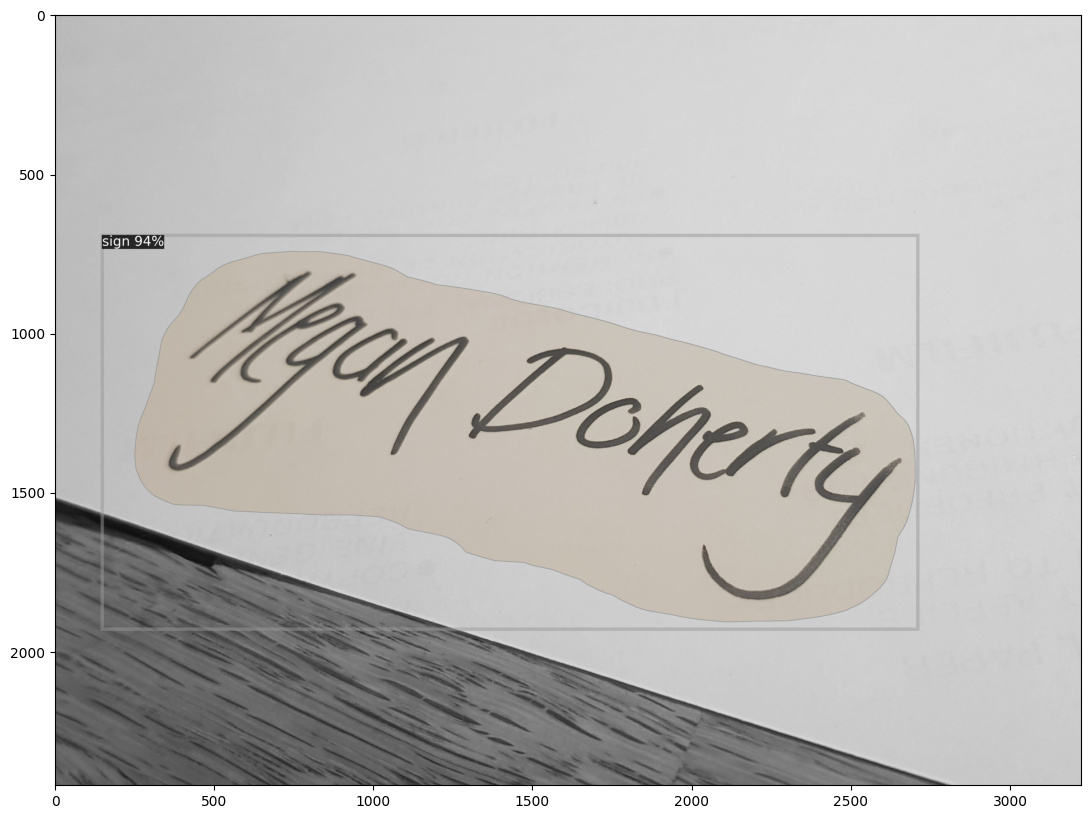

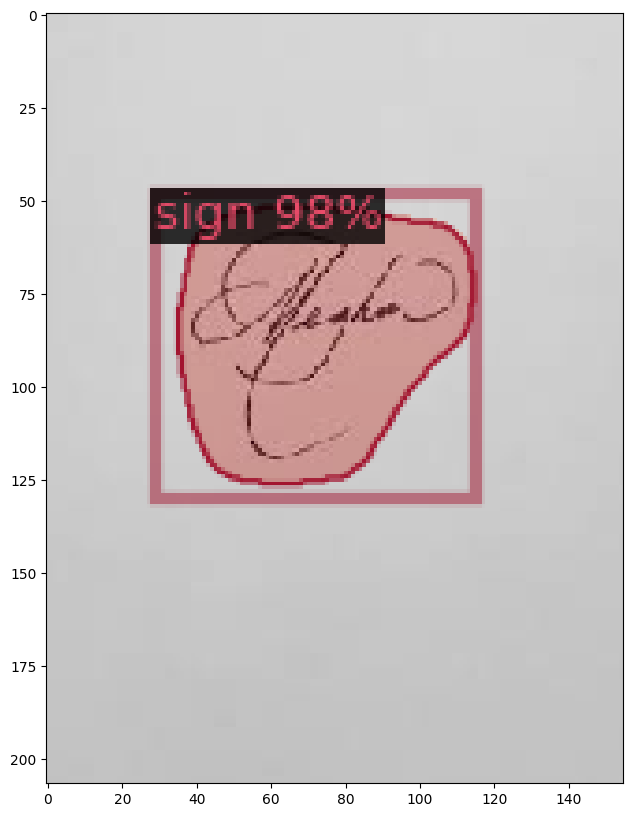

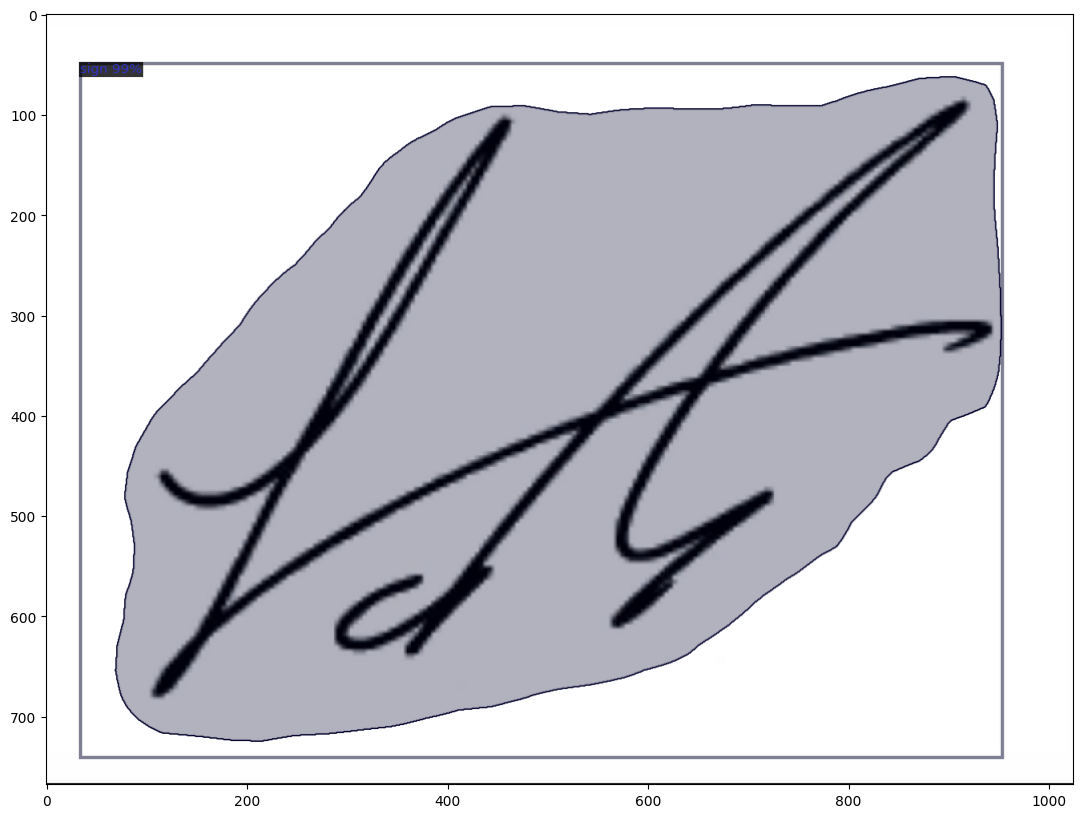

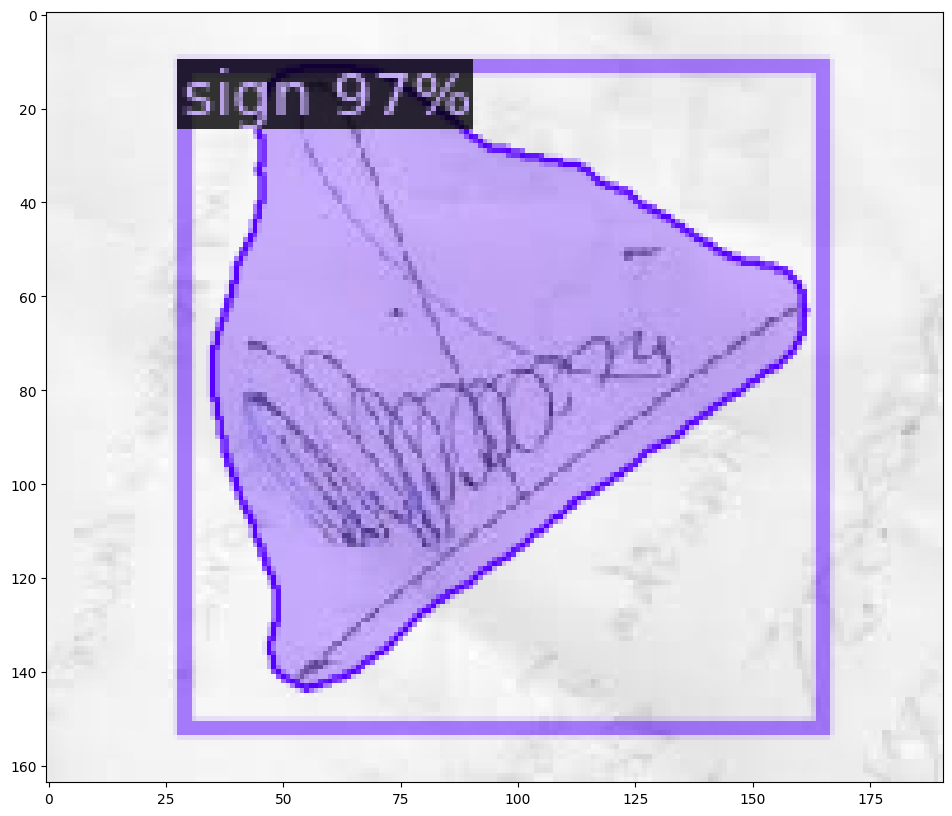

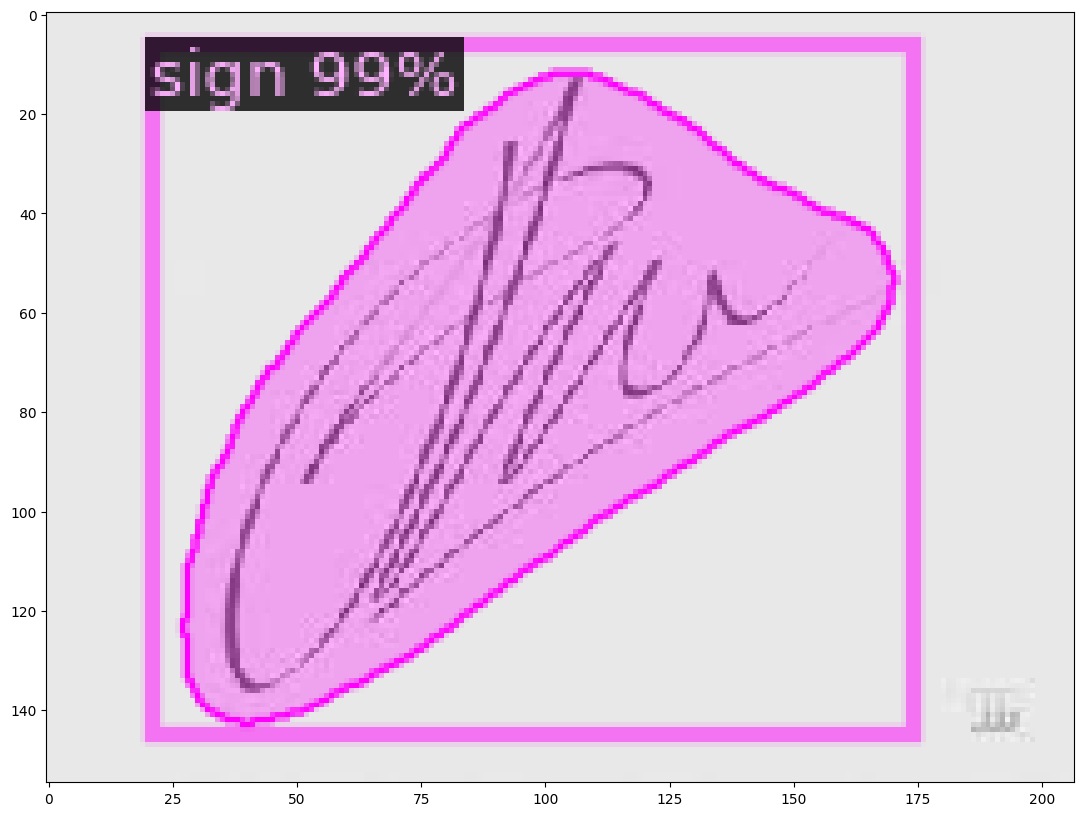

In [17]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("microcontroller_test")
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [15]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("microcontroller_test", ("bbox",), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "microcontroller_test")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

WARNING [05/21 10:33:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/21 10:33:25 d2.data.datasets.coco]: Loaded 10 images in COCO format from Microcontroller Segmentation/test.json
[05/21 10:33:25 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    sign    | 10           |
|            |              |
[05/21 10:33:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/21 10:33:25 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/21 10:33:25 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[05/21 10:33:25 d2.data.common]: Serialized dataset takes 0.00 MiB
[05/21 10:33:25 d2.evaluation.evaluator]: Start inference on 10 batches
[05/